In [0]:
# http://pytorch.org/

from copy import deepcopy

from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch
import torch.nn.functional as F
from torch.distributions import Categorical
from torch.autograd import Variable
from torch.nn import init
from torch.optim import Adam, SGD
import torch.nn as nn
import numpy as np
from scipy.signal import savgol_filter

from scipy.signal import savgol_filter

from torch.optim import Adam, SGD

import matplotlib.pyplot as plt
%matplotlib inline

device = "cpu"
if device == "cpu":
    from torch import FloatTensor
else:
    from torch.cuda import FloatTensor

In [0]:
import copy

import torch


def differentiable_gradient_step(module, loss, step_size, inplace=False):
    """A differentiable loss-minimizing gradient descent step on module parameters.
    Args:
        module: Perform gradient descent on parameters of this module.
            A `torch.nn.Module`.
        loss: The loss to minimize.
        step_size: The gradient descent step size.
        inplace: If true, modifies `module` in place. Otherwise, creates and
            returns a copy.
    Returns:
        module: The module with updated parameters after gradient descent.
            The original module object if `inplace` is True otherwise a copy.
    Warning:
        The output module parameters are turned into tensors.
        The Module class tries to disallow this so there might be some
        negative consequences. Be cautious when using the result.
    """
    gradients = torch.autograd.grad(loss, module.parameters(), create_graph=True, allow_unused=True)

    if not inplace:
        module = copy.deepcopy(module)

    for (param_name, param), gradient in zip(module.named_parameters(), gradients):
        name_parts = param_name.split(".")
        submodule = module
        for part in name_parts[:-1]:
            submodule = getattr(submodule, part)
        # Modules do not allow assigning variables to parameters.
        # Instead we have to directly modify the private _parameters dict.
        # This might cause other problems but at least it works for gradients.
        if gradient is not None:
          submodule._parameters[name_parts[-1]] = param - step_size * gradient
    return module

  
  

def get_second_order_grad(grads, xs):
    start = time.time()
    grads2 = []

    for grad in grads:
      for x in xs:
        grad = torch.reshape(grad, [-1])
        grads2_tmp = []
        for count, g in enumerate(grad):
            g2 = torch.autograd.grad(g, x, retain_graph=True, allow_unused=True)[0]
            g2 = torch.reshape(g2, [-1])
            grads2_tmp.append(g2.data.cpu().numpy())
        grads2_tmp=np.array(grads2_tmp)
        grads2.append(torch.from_numpy(grads2_tmp).to(device))

    return grads2



In [0]:
def weights_init(m, std):
  vals = list(m.parameters())[0]
  vals.data.normal_(0.0, std)

def get_return(agent_a, agent_b, overwrite = None, ent_regul_A=0, L2_regul_A=0):
  if overwrite is not None:
    batchsize = overwrite.data.numpy().shape[0]
#   print(weights_a)
    weights_a = overwrite
    agent_a_in_b = overwrite
  else:
    weights_a = list(agent_a.parameters())[0].transpose(1,0)
    batchsize = weights_a.data.numpy().shape[0]
  if stop_grad:
    agent_a_in_b = weights_a.clone().detach()
  else:
    agent_a_in_b = weights_a
  pi_b = nn.Softmax(1)( agent_b(  agent_a_in_b )*1) # prob of agent B cooperating given agent A's policy 
#   pi_b[:,0]=1
#   pi_b[:,1]=0
  rews = torch.tensor([[0.0, 0.0]]*batchsize )
  for u_b in [0,1]:
    p_u_b = pi_b[:,u_b]
    pi_a =  nn.Softmax(0)(torch.stack((weights_a[:,u_b],weights_a[:,u_b] * 0)))    # weird hack with *0
    # Entropy regularization
    if ent_regul_A:
      policy_a = nn.Sigmoid()(weights_a)
      entropies = policy_a * torch.log(policy_a) + (1-policy_a) * torch.log(1-policy_a)
      rews[:,0] -= ent_regul_A * torch.sum(entropies,1)
    # L2 regularization
    rews[:,0] -= L2_regul_A * weights_a.view(-1).dot(weights_a.view(-1))
    for u_a in [0, 1]:
      prob = pi_a[u_a] * p_u_b 
      # C  / D = 0 / 1. [-3, 0]
      rews[:,0]+= prob * payout[ u_a, u_b]   
      rews[:,1]+= prob * payout[ u_b, u_a]
  return -rews

def get_A_to_cooperate(agent_a, agent_b, overwrite = None, ent_regul_A=0):
  """Alternative get_return where B is rewarded for getting A to cooperate.
  A is rewarded for getting B to cooperate."""
  payout = torch.tensor(np.array([[-1.01,-2.01],[-1.0, -2.0]]), dtype=torch.float)
  if overwrite is not None:
    batchsize = overwrite.data.numpy().shape[0]
    weights_a = overwrite
    agent_a_in_b = overwrite
  else:
    weights_a = list(agent_a.parameters())[0].transpose(1,0)
    batchsize = weights_a.data.numpy().shape[0]
  if stop_grad:
    agent_a_in_b = weights_a.clone().detach()
  else:
    agent_a_in_b = weights_a
  pi_b = nn.Softmax(1)( agent_b(  agent_a_in_b )*1) # prob of agent B cooperating given agent A's policy 
#   pi_b[:,0]=1
#   pi_b[:,1]=0
  rews = torch.tensor([[0.0, 0.0]]*batchsize )
  for u_b in [0,1]:
    p_u_b = pi_b[:,u_b]
    pi_a =  nn.Softmax(0)(torch.stack((weights_a[:,u_b],weights_a[:,u_b] * 0)))    # weird hack with *0
    # Entropy regularization
    if ent_regul_A:
      policy_a = nn.Sigmoid()(weights_a)
      entropies = policy_a * torch.log(policy_a) + (1-policy_a) * torch.log(1-policy_a)
      rews[:,0] -= ent_regul_A * torch.sum(entropies,1)
    for u_a in [0, 1]:
      prob = pi_a[u_a] * p_u_b 
      # C  / D = 0 / 1. [-3, 0]
      rews[:,0]+= prob * payout[ u_a, u_b]   
      rews[:,1]+= prob * payout[ u_b, u_a]
  return -rews

seed 150 player B points: -3.0
ind  (0, 0)
pos -20.0 -20.0


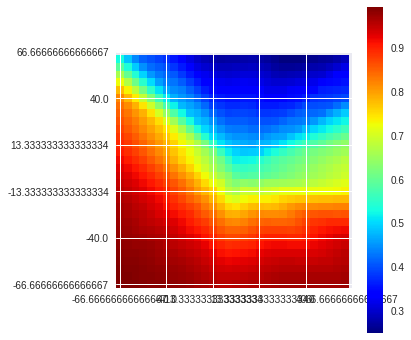

In [0]:


# Minimal example




def printnetwork(x_range):
  numvals = 30
  results = np.zeros((numvals, numvals))
  ticks = []
  for x in range(numvals):
    ticks.append( -x_range + x/numvals*2*x_range)
    for y in range(numvals):
      results[x, y ] = nn.Softmax(0)( agent_b(  torch.tensor([-x_range + x/numvals*2*x_range,-x_range + y/numvals*2*x_range] )) )[0] # prob of agent B cooperating given agentA's policy
  plt.imshow(results.T,cmap = 'jet', origin='lower')
  ax = plt.gca()
  ax.set_xticks(np.arange(0, numvals+1,numvals//5))
  ax.set_yticks(np.arange(0, numvals+1,numvals//5))
  ax.set_xticklabels((100*np.arange(-x_range, x_range+0.1, 1 /5 * 2* x_range))//1 / numvals)
  ax.set_yticklabels((100*np.arange(-x_range, x_range+0.1,  1 /5* 2* x_range))//1 / numvals)
  # plt.xticks(ticks)
  plt.colorbar()

def printagentaval(x_range):
  numvals = 100
  results = np.zeros((numvals, numvals, 2))
  ticks = []
  for x in range(numvals):
    ticks.append( -x_range + x/numvals*2*x_range)
    for y in range(numvals):
      overwrite = torch.tensor([[-x_range + x/numvals*2*x_range,-x_range + y/numvals*2*x_range]] )
      results[x, y ] =  -get_return(agent_a, agent_b, overwrite=overwrite).data 
  return results

plt.figure(figsize=(18,6))
t = True
f = False
x_range = 20
plt.subplot(1,3,1)
p = f
stop_grad = f
cooperative = f
dbg = f
# Seed 29 rocks! 

batchsize = 3
agent_a = nn.Sequential(
    nn.Linear(batchsize, 2, bias=False),
)

  

for m in range(150, 151):
  numvals = 30

  torch.manual_seed(m)

  nonlin = nn.Tanh() #nn.ReLU()
  nonlin = nn.ReLU()

  # torch.manual_seed(seed)

  agent_b = nn.Sequential(
      nn.Linear(2, 32),
      nonlin,
      nn.Linear(32, 32),
      nonlin,
  #     nn.Linear(32, 32),
  #     nn.ReLU(),
      nn.Linear(32, 2)
  )
  lrs = [0.05, 0.005]
  ops = [SGD, SGD]

  payout = torch.tensor(np.array([[-1.0,-3.0],[0.0, -2.0]]), dtype=torch.float)
  for i, net in enumerate([agent_a, agent_b]):
    net.optimizer = ops[i](net.parameters(), lr=lrs[i])
  printnetwork( x_range )

  results = printagentaval(x_range)


  titles = ['A', 'B']
  if p:
    for i in range( 2 ):
      plt.subplot(1,3, i + 2)
      plt.imshow(results[:,:,i].T,cmap = 'jet', origin='lower')
      ax = plt.gca()
      ax.set_xticks(np.arange(0, 101,20))
      ax.set_yticks(np.arange(0, 101,20))
      ax.set_xticklabels(np.arange(-x_range, x_range+1, 2*x_range//5))
      ax.set_yticklabels(np.arange(-x_range, x_range+1, 2*x_range//5))
      plt.colorbar()
      plt.title(titles[i])

  a = results[:,:,0]
  ind = np.unravel_index(np.argmax(a, axis=None), a.shape)

  print('seed', m, 'player B points:', (results[ind[0],ind[1],1]*10)//1 /10 )
  print('ind ', ind)
  
  print('pos', ((-x_range + ind[0]/numvals*2*x_range)*10 )//1 /10,((-x_range + ind[1]/numvals*2*x_range)*10 )//1 /10 )

In [0]:
def set_weight(m, overwrite):
  vals = list(m.parameters())[0]
  vals.data = overwrite

In [0]:
import torch
import time
%pdb on
# import pdb


# config A: 
# seed = 29
# x = 48
# y = 43

# config B:
seed = 107
x = 44
y = 37

# Config C (For Tanh nonlinearity)
# seed = 106 #player B points: -1.9675742387771606
# x = 18
# y = 88

# Hyperparams
numvals = 100   
x_range = 20    
steps = 100      # optim steps
vals_res = []
agent_a_steps = 200   # inner steps
lola = True     # fixed point LOLA
lrs = [0.1, 0.002] # before: [0.5, 0.002]
ops = [SGD, SGD]
ent_regul_A = 0
L2_regul_A = 0.1
return_fn = get_return # get_A_to_cooperate get_return

overwrite = torch.transpose(torch.tensor([[-x_range + x/numvals*2*x_range,-x_range + y/numvals*2*x_range]] ),1,0)
print('overwrite', overwrite)
set_weight( agent_a, overwrite)

nonlin = nn.ReLU() #nn.Tanh() 

torch.manual_seed(seed)

agent_b = nn.Sequential(
    nn.Linear(2, 32),
    nonlin,
#     nn.Linear(32, 32),
#     nonlin,
#     nn.Linear(32, 32),
#     nn.ReLU(),
    nn.Linear(32, 2)
)

for i, net in enumerate([agent_a, agent_b]):
  net.optimizer = ops[i](net.parameters(), lr=lrs[i])

plt.figure(figsize=(18, 50))
x_range = 8
for t in range(steps):
  plt.subplot(15,4, t+1)
#   printnetwork( x_range )

  results = printagentaval(x_range)
  a = results[:,:,0]
  ind = np.unravel_index(np.argmax(a, axis=None), a.shape)
#   print( ind )
#   values_pre_opt = agent_a.optimizer.param_groups[0]['params'][0].data.numpy()
  for i in range(1 ):
#     plt.subplot(1,3, i + 2)
    plt.imshow(results[:,:,i].T,cmap = 'jet', origin='lower')
    ax = plt.gca()
    ax.set_xticks(np.arange(0, 101,20))
    ax.set_yticks(np.arange(0, 101,20))
    ax.set_xticklabels((100*np.arange(-x_range, x_range+1, 20 /100 * 2* x_range))//1 / 100)
    ax.set_yticklabels((100*np.arange(-x_range, x_range+1, 20 /100 * 2* x_range))//1 / 100)

    plt.colorbar()
    plt.title(titles[i])

  values_pre_opt = agent_a.optimizer.param_groups[0]['params'][0].data.numpy()
  
  val_ind = [ max(0, min(100, ((x_val + x_range)*numvals/ (2 *x_range))//1) ) for x_val in values_pre_opt ]
  plt.scatter(val_ind[0], val_ind[1 ] )
  val_ind = [ (x_val + x_range)*numvals/ (2 *x_range) for x_val in values_pre_opt ]
#   plt.scatter( values_pre_opt[0], values_pre_opt[0], 'r')
#   if t % 100 == 0:
  print('step, ', t)

  # optimize the heck out of agent A
  for step in range( agent_a_steps ):
    objective1 = return_fn(agent_a, agent_b, ent_regul_A=ent_regul_A, L2_regul_A=L2_regul_A)[:,0].sum()
    agent_a.optimizer.zero_grad()
    objective1.backward()
    agent_a.optimizer.step()
    
  values_post_opt = agent_a.optimizer.param_groups[0]['params'][0].data.numpy()
  val_ind = [ max(0, min(100, ((x_val + x_range)*numvals/ (2 *x_range))//1) ) for x_val in values_post_opt ]
  plt.scatter(val_ind[0], val_ind[1 ])
  
  print( values_post_opt[:,0]  )
  rews = return_fn(agent_a, agent_b, ent_regul_A=ent_regul_A, L2_regul_A=L2_regul_A)
  vals_res.append(-rews[0,1].data.numpy())
  va = rews[:,0].sum()
  vb = rews[:,1].sum()
  agent_a.optimizer.zero_grad()
  agent_b.optimizer.zero_grad()

  xs = agent_a.optimizer.param_groups[0]['params']
  ys = agent_b.optimizer.param_groups[0]['params']
  vb_y = torch.autograd.grad(vb, ys, create_graph=True, retain_graph=True ) # first order gradient
  
  if lola:
    va_x = torch.autograd.grad(va, xs, create_graph=True, retain_graph=True )  # first order gradient
    va_xx = get_second_order_grad(va_x, xs)  # second order gradient

    vb_x = torch.autograd.grad(vb, xs, create_graph=True, retain_graph=True )  # first order gradient
    va_xy = get_second_order_grad(va_x, ys)  # second order gradient

    for i in range(len( ys )):
      delta_y = vb_y[i] - torch.reshape( va_xy[i].transpose(1,0) .matmul((va_xx[0].inverse()).matmul(vb_x[0])),vb_y[i].shape)
      vals = list(agent_b.parameters())[i]
      vals.data =-delta_y * lrs[1] + agent_b.optimizer.param_groups[0]['params'][i] 
  else:
     for i in range(len( ys )):
      delta_y = vb_y[i]
      vals = list(agent_b.parameters())[i]
      vals.data =-delta_y * lrs[1]  + agent_b.optimizer.param_groups[0]['params'][i] 
    
  rews = -return_fn(agent_a, agent_b, ent_regul_A=ent_regul_A, L2_regul_A=L2_regul_A)
# plt.plot(vals_res  )

Automatic pdb calling has been turned ON
overwrite tensor([[-2.4000],
        [-5.2000]])
step,  0
[-0.58714664 -0.37144727]
step,  1
[-0.58222944 -0.36773297]
step,  2
[-0.5772053 -0.3644732]
step,  3
[-0.57689416 -0.36364233]
step,  4
[-0.57531565 -0.36208174]
step,  5
[-0.57654876 -0.36210027]
step,  6
[-0.5761604  -0.36112428]
step,  7
[-0.57709897 -0.360835  ]
step,  8
[-0.57682693 -0.35986263]
step,  9
[-0.57744104 -0.35933787]
step,  10
[-0.57618463 -0.35777467]
step,  11
[-0.57766044 -0.35775125]
step,  12
[-0.576327   -0.35608852]
step,  13
[-0.5770833  -0.35561645]
step,  14
[-0.5774563  -0.35490176]
step,  15
[-0.5730133 -0.3516671]
step,  16
[-0.5685673 -0.3483972]
step,  17
[-0.5641209  -0.34509295]
step,  18
[-0.5596753 -0.3417551]
step,  19
[-0.55523163 -0.33838463]
step,  20
[-0.550791  -0.3349824]
step,  21
[-0.5463547 -0.3315492]
step,  22
[-0.54192364 -0.32808608]
step,  23
[-0.53749907 -0.3245939 ]
step,  24
[-0.50856745 -0.31740776]
step,  25
[-0.50506717 -0.313936

ValueError: ignored

> /usr/local/lib/python3.6/dist-packages/matplotlib/axes/_subplots.py(60)__init__()
     58                     raise ValueError(
     59                         ("num must be 1 <= num <= {maxn}, not {num}"
---> 60                         ).format(maxn=rows*cols, num=num))
     61                 self._subplotspec = GridSpec(
     62                         rows, cols, figure=self.figure)[int(num) - 1]



In [0]:
plt.plot(vals_res  )

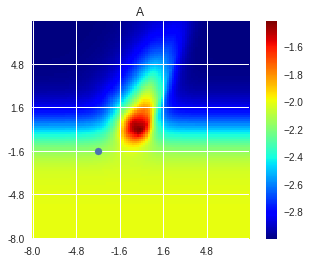

In [0]:
i  = 0
from matplotlib.ticker import FormatStrFormatter

plt.imshow(results[:,:,i].T,cmap = 'jet', origin='lower')
ax = plt.gca()
ax.set_xticks(np.arange(0, 101,20))
ax.set_yticks(np.arange(0, 101,20))
ax.set_xticklabels((100*np.arange(-x_range, x_range+0.1, 20 /100 * 2* x_range))//1 / 100)
ax.set_yticklabels((100*np.arange(-x_range, x_range+0.1, 20 /100 * 2* x_range))//1 / 100)

plt.colorbar()
plt.title(titles[i])

plt.scatter( 30, 40)

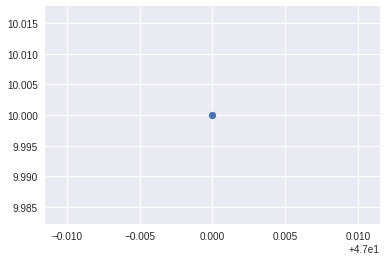

In [0]:
plt.scatter(val_ind[0], val_ind[1 ] )

seed 199 player B points: -1.606716513633728
ind  (49, 50)


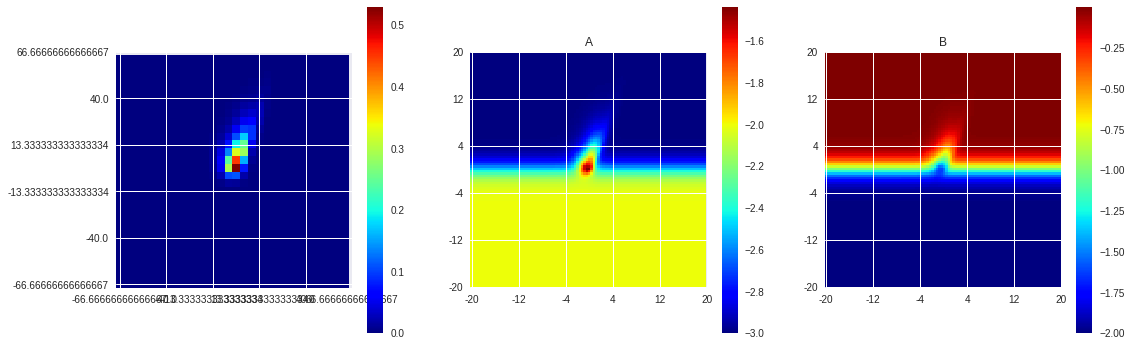

In [0]:
plt.figure(figsize=(18,6))

x_range = 20
plt.subplot(1,3,1)
p = t

# Seed 29 rocks! 

batchsize = 1

printnetwork( x_range )

results = printagentaval(x_range)


titles = ['A', 'B']
if p:
  for i in range( 2 ):
    plt.subplot(1,3, i + 2)
    plt.imshow(results[:,:,i].T,cmap = 'jet', origin='lower')
    ax = plt.gca()
    ax.set_xticks(np.arange(0, 101,20))
    ax.set_yticks(np.arange(0, 101,20))
    ax.set_xticklabels(np.arange(-x_range, x_range+1, 2*x_range//5))
    ax.set_yticklabels(np.arange(-x_range, x_range+1, 2*x_range//5))
    plt.colorbar()
    plt.title(titles[i])

a = results[:,:,0]
ind = np.unravel_index(np.argmax(a, axis=None), a.shape)

print('seed', m, 'player B points:', results[ind[0],ind[1],1])
print('ind ', ind)

In [0]:
# delta_y = vb_y - torch.reshape( va_xy.transpose(1,0) .matmul((va_xx.inverse()).matmul(vb_x)),vb_y.shape)
# for i in range(len( ys )):
#   print(i)
# #   print('before', agent_b.optimizer.param_groups[0]['params'][i])
#   delta_y = vb_y[i] - torch.reshape( va_xy[i].transpose(1,0) .matmul((va_xx[0].inverse()).matmul(vb_x[0])),vb_y[i].shape)
#   agent_b.optimizer.param_groups[0]['params'][i] =delta_y  + agent_b.optimizer.param_groups[0]['params'][i] 
#   print('after', agent_b.optimizer.param_groups[0]['params'][i])
#   # vb_y
# # agent_b.optimizer.param_groups[0]['params']

In [0]:
# print('vb_y', vb_y[i].shape)
# print('vb_x', vb_x[0].shape)
# print('va_xy', va_xy[i].shape)
# print('va_x', va_x)
# # va_xy
# print(vb_x)
xs = agent_a.optimizer.param_groups[0]['params']
va_x = torch.autograd.grad(va, xs, create_graph=True, retain_graph=True )  # first order gradient
grads = va_x
xs =  agent_b.optimizer.param_groups[0]['params']
grads2 = []
for grad in grads:
  for x in xs:
    grad = torch.reshape(grad, [-1])
    grads2_tmp = []
    for count, g in enumerate(grad):
        g2 = torch.autograd.grad(g, x, retain_graph=True, allow_unused=True)[0]
        g2 = torch.reshape(g2, [-1])
        grads2_tmp.append(g2.data.cpu().numpy())
    grads2_tmp=np.array(grads2_tmp)
    grads2.append(torch.from_numpy(grads2_tmp).to(device))

In [0]:
grads2[0].shape

torch.Size([2, 64])

agent_a ret  -1.0051143
agent_b ret  -2.4766908


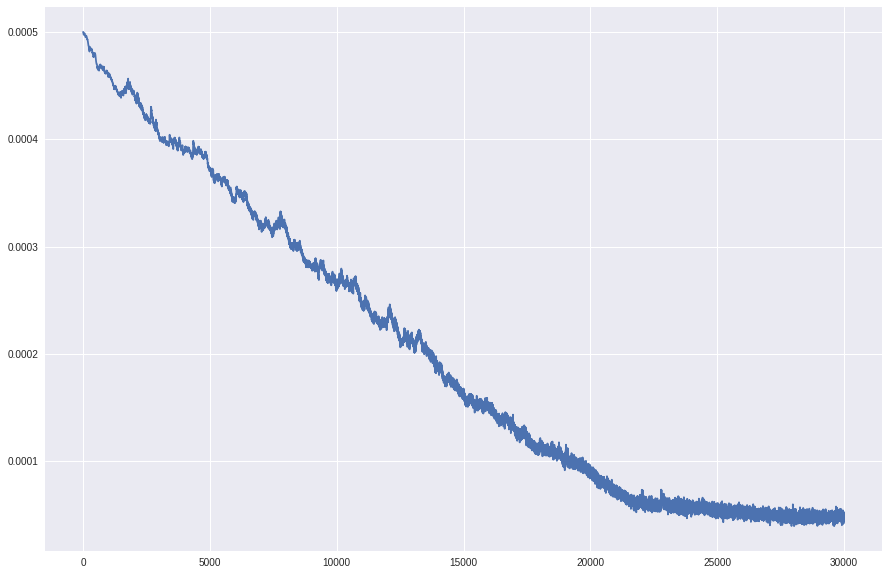

In [0]:
# Batch it like you mean it.

def printnetwork(x_range):
  numvals = 30
  results = np.zeros((numvals, numvals))
  ticks = []
  for x in range(numvals):
    ticks.append( -x_range + x/numvals*2*x_range)
    for y in range(numvals):
      results[x, y ] = nn.Softmax(0)( agent_b(  torch.tensor([-x_range + x/numvals*2*x_range,-x_range + y/numvals*2*x_range] )) )[0] # prob of agent B cooperating given agentA's policy
  plt.imshow(results.T,cmap = 'jet', origin='lower')
  ax = plt.gca()
  ax.set_xticks(np.arange(0, numvals+1,numvals//5))
  ax.set_yticks(np.arange(0, numvals+1,numvals//5))
  ax.set_xticklabels(np.arange(-5, 6, 2))
  ax.set_yticklabels(np.arange(-5, 6, 2))
  # plt.xticks(ticks)
  plt.colorbar()

  None
  

plt.figure(figsize = (15,10))
t=True; f=False
stop_grad = f
cooperative = f
dbg = f
torch.manual_seed(199)
training_eps = 1 #8000
n_inner_opt_a = 0 #1 == Agent A is LOLA
n_inner_opt_b = 0 #1 == Agent B is LOLA
lr_b = 0.0005
lr_a = 0.0005
agent_a_steps = 30000
std = 3
lr_in = lr_a
batchsize = 128
agent_a = nn.Sequential(
    nn.Linear(batchsize, 2),
)

agent_b = nn.Sequential(
    nn.Linear(2, 32),
    nn.ReLU(),
    nn.Linear(32, 32),
    nn.ReLU(),
#     nn.Linear(32, 32),
#     nn.ReLU(),
    nn.Linear(32, 2)
)
lrs = [lr_a, lr_b ]
ops = [Adam, Adam]
payout = torch.tensor(np.array([[-1.0,-3.0],[0.0, -2.0]]), dtype=torch.float)
for i, net in enumerate([agent_a, agent_b]):
  net.optimizer = ops[i](net.parameters(), lr=lrs[i])

# Make it cooperative if you want to
if cooperative:
  payout = (payout + torch.transpose( payout,0,1))/2

def get_return(agent_a, agent_b, overwrite = None):
  if overwrite is not None:
    batchsize = overwrite.data.numpy().shape[0]
#   print(weights_a)
    weights_a = overwrite
    agent_a_in_b = overwrite
  else:
    weights_a = list(agent_a.parameters())[0].transpose(1,0)
    batchsize = weights_a.data.numpy().shape[0]
  if stop_grad:
    agent_a_in_b = weights_a.clone().detach()
  else:
    agent_a_in_b = weights_a
  pi_b = nn.Softmax(1)( agent_b(  agent_a_in_b ) ) # prob of agent B cooperating given agent A's policy 
  rews = torch.tensor([[0.0, 0.0]]*batchsize )
  for u_b in [0,1]:
    p_u_b = pi_b[:,u_b]
    pi_a =  nn.Softmax(0)(torch.stack((weights_a[:,u_b],weights_a[:,u_b] * 0)))
    for u_a in [0, 1]:
      prob = pi_a[u_a] * p_u_b 
      # C  / D = 0 / 1. [-3, 0]
      rews[:,0]+= prob * payout[ u_a, u_b]    
      rews[:,1]+= prob * payout[ u_b, u_a]
  return -rews

def printagentaval(x_range):
  plt.figure(figsize=(12,6))
  numvals = 100
  results = np.zeros((numvals, numvals, 2))
  ticks = []
  for x in range(numvals):
    ticks.append( -x_range + x/numvals*2*x_range)
    for y in range(numvals):
      overwrite = torch.tensor([[-x_range + x/numvals*2*x_range,-x_range + y/numvals*2*x_range]] )
      results[x, y ] =  -get_return(agent_a, agent_b, overwrite = overwrite).data 
#       results[x, y ] = nn.Softmax(0)( agent_b( ) )[0] # prob of agent B cooperating given agent A's policy 
  titles = ['A', 'B']
  for i in range( 2 ):
    plt.subplot(1,2, i + 1)
    plt.imshow(results[:,:,i].T,cmap = 'jet', origin='lower')
    ax = plt.gca()
    ax.set_xticks(np.arange(0, 101,20))
    ax.set_yticks(np.arange(0, 101,20))
    ax.set_xticklabels(np.arange(-5, 6, 2))
    ax.set_yticklabels(np.arange(-5, 6, 2))
  # plt.xticks(ticks)
    plt.colorbar()
    plt.title(titles[i])

def LOLA_step(net1, net2_, agent_a, n_inner_opt):
    # net2_ = inner agent
    # net1 = outer agent
    # Inner optimization
    agent_b = (agent_a + 1) % 2 
    outer_agent = agent_a
    inner_agent = (outer_agent+ 1) % 2 
    nets = [ net1, net2_ ]
    net_a = nets[agent_a]
    net_b = nets[agent_b]
    # Warning: This is kind of weird - doing the .sum() below is only valid for agent A in the lookahead step
    for k in range(n_inner_opt):
        objective2 = get_return(net_a, net_b)[:,inner_agent].sum()
        differentiable_gradient_step(net2_, objective2, lr_in, inplace=True)
    # Outer optimization
    objective1 = get_return(net_a, net_b)[:,outer_agent].mean()
    net1.optimizer.zero_grad()
    objective1.backward()
    net1.optimizer.step()
res = []   
for update in range(1):
    vals = []
    weights = []
#     if  update % (training_eps// 12) == 0:
#       if 1 + (update // (training_eps// 12)) < 13:
#         plt.subplot(2, 6,  1 + (update // (training_eps// 12)) )
#         printnetwork()
    weights_init(agent_a, std)
    for step in range( agent_a_steps ):
      weights_before = list(agent_a.parameters())[0].transpose(1,0).data.clone()
      objective1 = get_return(agent_a, agent_b)[:,0].sum()
      agent_a.optimizer.zero_grad()
      objective1.backward()
      agent_a.optimizer.step()
      weights_after = list(agent_a.parameters())[0].transpose(1,0).data.clone()
      vals.append(weights_before - weights_after)
      weights.append(weights_after)
    
    rews = -get_return(agent_a, agent_b).mean(0)
    res.append( rews.data.numpy())
    
labels = ['nolola', 'lola']
plt.savefig('batched_LAH_' +str(n_inner_opt_b) +'_LRA_' + str(lr_a) + '.pdf' )


x_a = np.array(res)[:,0]
x_b = np.array(res)[:,1]

if False:
  plt.plot(savgol_filter(x_a, 51, 3), 'r', label='Agent_a')
  plt.plot(savgol_filter(x_b, 51, 3), 'b', label='Agent_b')
  plt.legend()
  None

vals_x = training_eps // 2
x_a = np.array(res)[:,0]
x_b = np.array(res)[:,1]

print('agent_a ret ', np.mean(x_a[vals_x:]))
print('agent_b ret ', np.mean(x_b[vals_x:]))
# plt.figure(figsize = (5,5))
# # printnetwork()
None
plt.plot([abs(v.numpy()).mean() for v in vals])

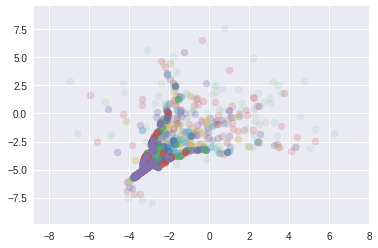

In [0]:
# plt.plot([abs(v.numpy()).mean() for v in weights])
for i in range(agent_a_steps)[ ::agent_a_steps//10]:
  plt.scatter(weights[i].numpy()[:,0], weights[i].numpy()[:,1], alpha = i / agent_a_steps )

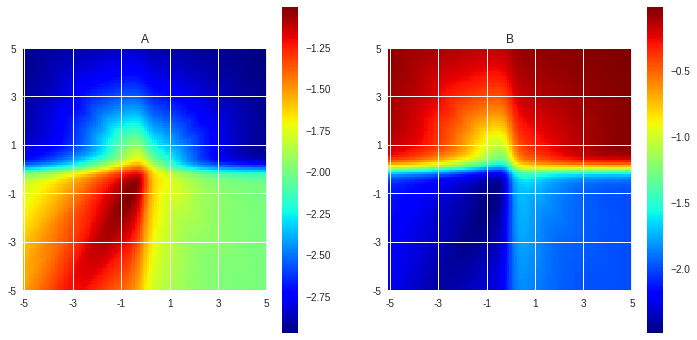

In [0]:
# def printagentaval():
#   plt.figure(figsize=(12,6))
#   numvals = 100
#   x_range = 5
#   results = np.zeros((numvals, numvals, 2))
#   ticks = []
#   for x in range(numvals):
#     ticks.append( -x_range + x/numvals*2*x_range)
#     for y in range(numvals):
#       overwrite = torch.tensor([[-x_range + x/numvals*2*x_range,-x_range + y/numvals*2*x_range]] )
#       results[x, y ] =  -get_return(agent_a, agent_b, overwrite = overwrite).data 
#   titles = ['A', 'B']
#   for i in range( 2 ):
#     plt.subplot(1,2, i + 1)
#     plt.imshow(results[:,:,i].T,cmap = 'jet', origin='lower')
#     ax = plt.gca()
#     ax.set_xticks(np.arange(0, 101,20))
#     ax.set_yticks(np.arange(0, 101,20))
#     ax.set_xticklabels(np.arange(-5, 6, 2))
#     ax.set_yticklabels(np.arange(-5, 6, 2))
#     plt.colorbar()
#     plt.title(titles[i])
printagentaval(30)
# -get_return(agent_a, agent_b, overwrite = overwrite) 

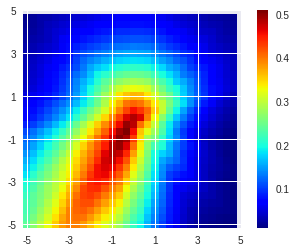

In [0]:
printnetwork(30)


agent_a ret  -2.1187828
agent_b ret  -1.0239877


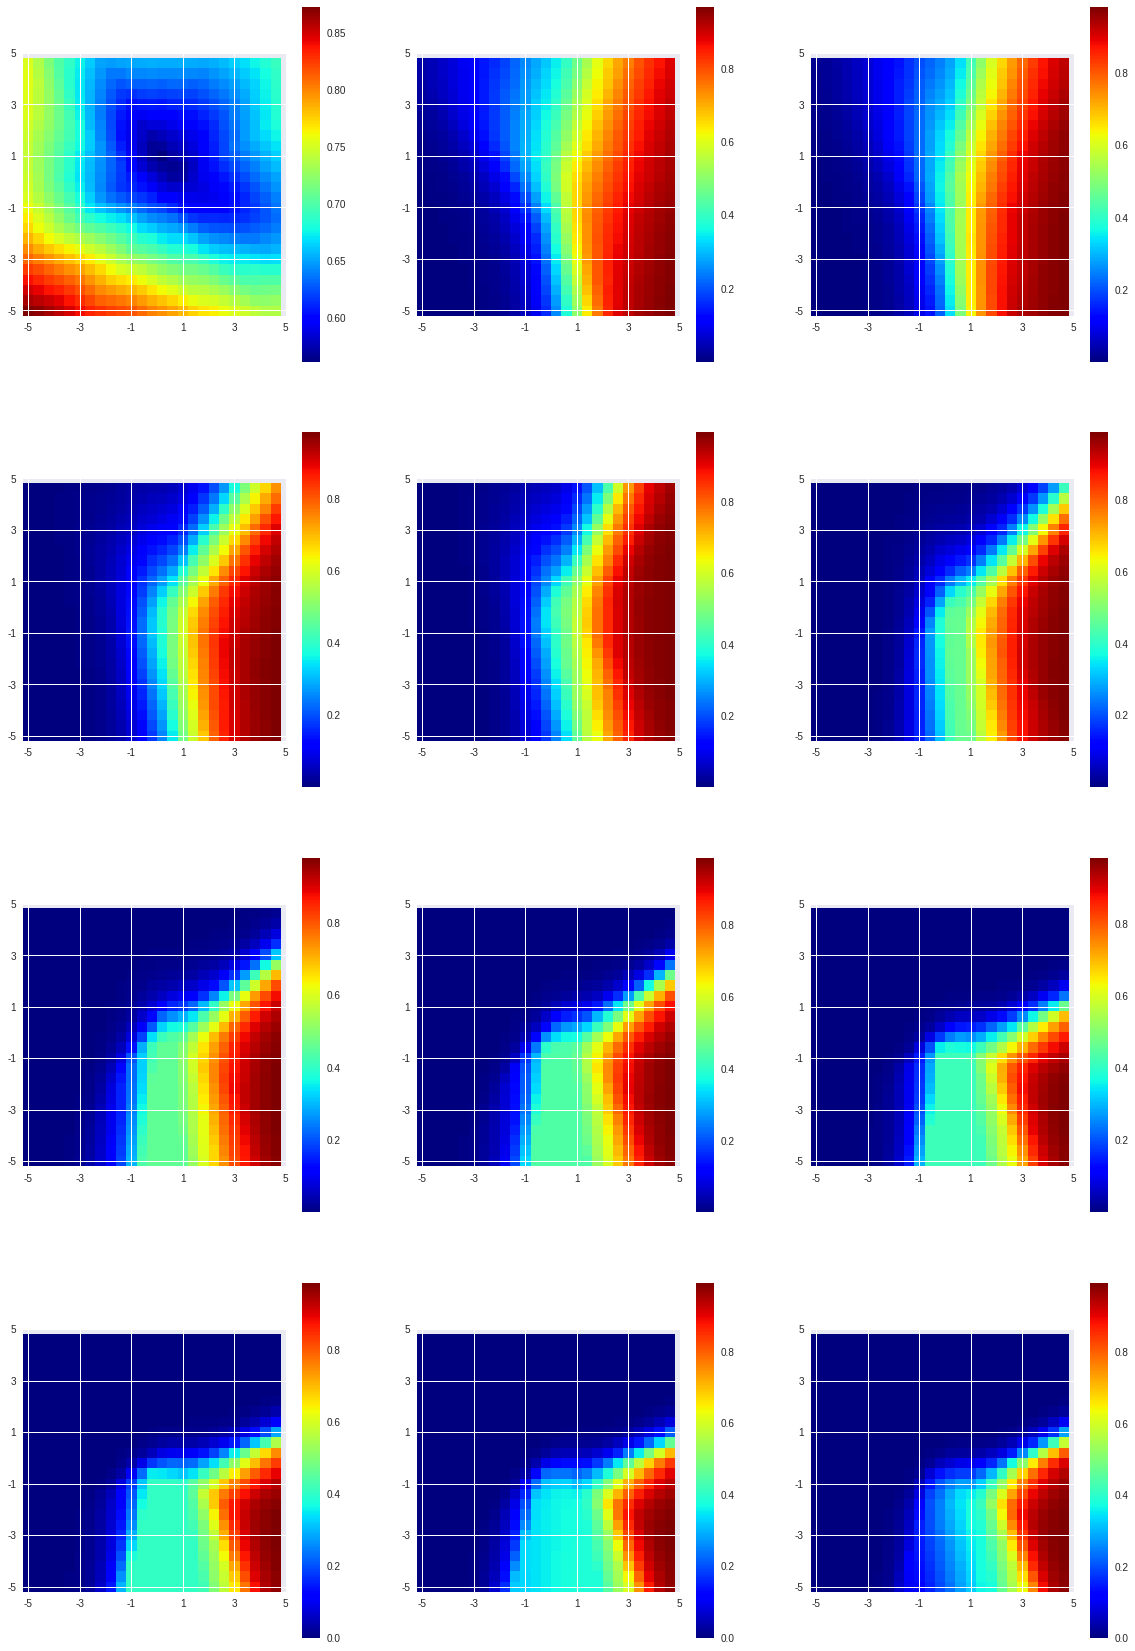

In [0]:
# Best response training w/ and w/o LOLA. Awesome stuff.
plt.figure(figsize = (20,30))
t=True; f=False
stop_grad = f
cooperative = f
dbg = f
torch.manual_seed(3)
learners = [0,1]
training_eps = 50000 #8000
n_inner_opt_a = 0 #1 == Agent A is LOLA
n_inner_opt_b = 10 #1 == Agent B is LOLA
lr_b = 0.0005
lr_a = 1.0
std = 3
lr_in = lr_a
agent_a = nn.Sequential(
    nn.Linear(2, 1),
)

agent_b = nn.Sequential(
    nn.Linear(2, 32),
    nn.ReLU(),
    nn.Linear(32, 32),
    nn.ReLU(),
    nn.Linear(32, 2)
)
lrs = [lr_a, lr_b ]
ops = [SGD, Adam]
payout = torch.tensor(np.array([[-1.0,-3.0],[0.0, -2.0]]), dtype=torch.float)
printnetwork()
for i, net in enumerate([agent_a, agent_b]):
  net.optimizer = ops[i](net.parameters(), lr=lrs[i])

# Make it cooperative if you want to
if cooperative:
  payout = (payout + torch.transpose( payout,0,1))/2

def get_return(agent_a, agent_b, overwrite = None):
  
  if overwrite is not None:
#   print(weights_a)
    weights_a = overwrite
    agent_a_in_b = overwrite
  else:
    weights_a = list(agent_a.parameters())[0][0]
    if stop_grad:
      agent_a_in_b = weights_a.clone().detach()
    else:
      agent_a_in_b = weights_a
  pi_b = nn.Softmax(0)( agent_b(  agent_a_in_b ) ) # prob of agent B cooperating given agent A's policy 
  rews = torch.tensor([0.0, 0.0] )
  for u_b in [0,1]:
    p_u_b = pi_b[u_b]
    pi_a =  nn.Softmax(0)(torch.stack((weights_a[u_b],weights_a[u_b] * 0)))
    for u_a in [0, 1]:
      prob = pi_a[u_a] * p_u_b 
      # C  / D = 0 / 1. [-3, 0]
      rews[0]+= prob * payout[ u_a, u_b]    
      rews[1]+= prob * payout[ u_b, u_a]
  return -rews

def printagentaval():
  plt.figure(figsize=(12,6))
  numvals = 100
  x_range = 5
  results = np.zeros((numvals, numvals, 2))
  ticks = []
  for x in range(numvals):
    ticks.append( -x_range + x/numvals*2*x_range)
    for y in range(numvals):
      overwrite = torch.tensor([-x_range + x/numvals*2*x_range,-x_range + y/numvals*2*x_range] )
      results[x, y ] =  -get_return(agent_a, agent_b, overwrite = overwrite).data 
#       results[x, y ] = nn.Softmax(0)( agent_b( ) )[0] # prob of agent B cooperating given agent A's policy 
  titles = ['A', 'B']
  for i in range( 2 ):
    plt.subplot(1,2, i + 1)
    plt.imshow(results[:,:,i].T,cmap = 'jet', origin='lower')
    ax = plt.gca()
    ax.set_xticks(np.arange(0, 101,20))
    ax.set_yticks(np.arange(0, 101,20))
    ax.set_xticklabels(np.arange(-5, 6, 2))
    ax.set_yticklabels(np.arange(-5, 6, 2))
  # plt.xticks(ticks)
    plt.colorbar()
    plt.title(titles[i])

def LOLA_step(net1, net2_, agent_a, n_inner_opt):
    # net2_ = inner agent
    # net1 = outer agent
    # Inner optimization
    agent_b = (agent_a + 1) % 2 
    outer_agent = agent_a
    inner_agent = (outer_agent+ 1) % 2 
    nets = [ net1, net2_ ]
    net_a = nets[agent_a]
    net_b = nets[agent_b]
    for k in range(n_inner_opt):
        objective2 = get_return(net_a, net_b)[inner_agent]
        differentiable_gradient_step(net2_, objective2, lr_in, inplace=True)
    # Outer optimization
    objective1 = get_return(net_a, net_b)[outer_agent]
    net1.optimizer.zero_grad()
    objective1.backward()
    net1.optimizer.step()
res = []   
for update in range(training_eps):
    if  update % (training_eps// 12) == 0:
      print(update)
      if 1 + (update // (training_eps// 12)) < 13:
        plt.subplot(4, 3,  1 + (update // (training_eps// 12)) )
        printnetwork()

    weights_init(agent_a, std)
    net1 = agent_a
    net2 = agent_b
    if n_inner_opt_a + n_inner_opt_b > 0:
      net2_ = deepcopy(net2).to(device)
      net1_ = deepcopy(net1).to(device)
    else:
      net2_ = net2 #deepcopy(net2).to(device)
      net1_ = net1 #deepcopy(net1).to(device)
    if dbg:
      print('before, ', list(agent_a.parameters())[0][0])
    LOLA_step(net1, net2_, 0, n_inner_opt_a)
    if dbg:
      print('after, ', list(agent_a.parameters())[0][0])
    LOLA_step(net2, net1_, 1, n_inner_opt_b )   
    
    rews = -get_return(agent_a, agent_b)
    res.append( rews.data.numpy())
    
labels = ['nolola', 'lola']
plt.savefig('policy_LAH_' +str(n_inner_opt_b) +'_LRA_' + str(lr_a) + '.pdf' )
# results:

x_a = np.array(res)[:,0]
x_b = np.array(res)[:,1]

if False:
  plt.plot(savgol_filter(x_a, 51, 3), 'r', label='Agent_a')
  plt.plot(savgol_filter(x_b, 51, 3), 'b', label='Agent_b')
  plt.legend()
  None

vals = training_eps // 2
x_a = np.array(res)[:,0]
x_b = np.array(res)[:,1]

print('agent_a ret ', np.mean(x_a[vals:]))
print('agent_b ret ', np.mean(x_b[vals:]))

# printnetwork()

In [0]:

weights_a = list(agent_a.parameters())[0].transpose(1,0)
if stop_grad:
  agent_a_in_b = weights_a.clone().detach()
else:
  agent_a_in_b = weights_a
pi_b = nn.Softmax(1)( agent_b(  agent_a_in_b ) ) # prob of agent B cooperating given agent A's policy 
rews = torch.tensor([[0.0, 0.0]]*batchsize )
probs = torch.tensor([[0.0, 0.0]]*batchsize )

for u_b in [0,1]:
  p_u_b = pi_b[:,u_b]
  pi_a =  nn.Softmax(0)(torch.stack((weights_a[:,u_b],weights_a[:,u_b] * 0)))
  for u_a in [0, 1]:
    prob = pi_a[u_a] * p_u_b 
    # C  / D = 0 / 1. [-3, 0]
    rews[:,0]+= prob * payout[ u_a, u_b]    
    rews[:,1]+= prob * payout[ u_b, u_a]
    probs[:,0] +=prob


In [0]:
rews

tensor([-0.4423, -2.1177], grad_fn=<NegBackward>)

In [0]:
prob

tensor([0.0330, 0.0016, 0.0251, 0.0016, 0.0235, 0.0000, 0.0245, 0.0210, 0.0006,
        0.0218, 0.0111, 0.0355, 0.0223, 0.0284, 0.0085, 0.0259, 0.0229, 0.0007,
        0.0120, 0.0203, 0.0040, 0.0197, 0.0269, 0.0133, 0.0439, 0.0365, 0.0012,
        0.0016, 0.0193, 0.0001, 0.0282, 0.0264], grad_fn=<ThMulBackward>)

In [0]:
np.random.rand(1)

In [0]:
printagentaval()

In [0]:
min(1,n_inner_opt_b)

In [0]:
x_a = np.array(res)[:,0]
x_b = np.array(res)[:,1]

plt.plot(savgol_filter(x_a, 51, 3), 'r', label='Agent_a')
plt.plot(savgol_filter(x_b, 51, 3), 'b', label='Agent_b')
plt.legend()
None

In [0]:
plt.figure(figsize=(13,5))
plt.subplot(1,2,1)
plt.scatter(x_a[4000:],x_b[4000:],alpha = 0.2)

None

plt.subplot(1,2,2)
plt.scatter(x_a[:4000],x_b[:4000],alpha = 0.2)
None

In [0]:
#With agent a learning

vals = 4000
plt.figure(figsize=(13,5))
plt.subplot(1,2,1)
plt.hist(x_a[vals:])
None

plt.subplot(1,2,2)
plt.hist(x_b[vals:])
None
print('agent_a ret ', np.mean(x_a[vals:]))
print('agent_b ret ', np.mean(x_b[vals:]))

In [0]:
#No agent_a learning
vals = 4000
plt.figure(figsize=(13,5))
plt.subplot(1,2,1)
plt.hist(x_a[vals:])
None

plt.subplot(1,2,2)
plt.hist(x_b[vals:])
None
print('agent_a ret ', np.mean(x_a[vals:]))
print('agent_b ret ', np.mean(x_b[vals:]))

In [0]:
# take away: when B is LOLA, it can exploit agent A. But only if no stopgrad. 
# LOLA implementation
t=True; f=False
stop_grad = f
cooperative = f
torch.manual_seed(0)
learners = [0,1]
training_eps = 30000
n_inner_opt_a = 1 #1 == Agent A is LOLA
n_inner_opt_b = 1  #1 == Agent B is LOLA
lr = 0.1
lr_in = 1.
agent_a = nn.Sequential(
    nn.Linear(2, 1),
)

agent_b = nn.Sequential(
#     nn.Linear(2, 32),
#     nn.ReLU(),
#     nn.Linear(32, 32),
#     nn.ReLU(),
    nn.Linear(2, 2)
)

payout = torch.tensor(np.array([[-1.0,-3.0],[0.0, -2.0]]), dtype=torch.float)

for net in [agent_a, agent_b]:
  net.optimizer = SGD(net.parameters(), lr=lr)

# Make it cooperative if you want to
if cooperative:
  payout = (payout + torch.transpose( payout,0,1))/2

def get_return(agent_a, agent_b):
  weights_a = list(agent_a.parameters())[0][0]  # diff-able?
  if stop_grad:
    agent_a_in_b = weights_a.clone().detach()
  else:
    agent_a_in_b = weights_a
  pi_b = nn.Softmax(0)( agent_b(  agent_a_in_b ) ) # prob of agent B cooperating given agent A's policy 
  rews = torch.tensor([0.0, 0.0] )
  for u_b in [0,1]:
    p_u_b = pi_b[u_b]
    pi_a =  nn.Softmax(0)(torch.stack((weights_a[u_b],weights_a[u_b] * 0)))
    for u_a in [0, 1]:
      prob = pi_a[u_a] * p_u_b 
      # C  / D = 0 / 1. [-3, 0]
      rews[0]+= prob * payout[ u_a, u_b]    
      rews[1]+= prob * payout[ u_b, u_a]
  return -rews


def LOLA_step(net1, net2_, agent_a, n_inner_opt):
    # net2_ = inner agent
    # net1 = outer agent
    # Inner optimization
    agent_b = (agent_a + 1) % 2 
    outer_agent = agent_a
    inner_agent = (outer_agent+ 1) % 2 
    nets = [ net1, net2_ ]
    net_a = nets[agent_a]
    net_b = nets[agent_b]
#     current = list(net2_.parameters())
#     print( "before lookahead", )
    for k in range(n_inner_opt):
        objective2 = get_return(net_a, net_b)[inner_agent]
#              param = param - lr_in * grad2[i]
#              print( "after lookahead", list(net2_.parameters())[i])
        differentiable_gradient_step(net2_, objective2, lr_in, inplace=True)
#     print( "after lookahead", list(net2_.parameters()))          
#     new = list(net2_.parameters())
#     print( agent_a)
#     for i in range( len( new)):
#       print( 'diffs', i, new[i]-current[i])
    # Outer optimization
    objective1 = get_return(net_a, net_b)[outer_agent]
    net1.optimizer.zero_grad()
    objective1.backward()
    net1.optimizer.step()
res = []   
for update in range(training_eps):
    net1 = agent_a
    net2 = agent_b
    net2_ = deepcopy(net2).to(device)
    net1_ = deepcopy(net1).to(device)
    LOLA_step(net1, net2_, 0, n_inner_opt_a)
    LOLA_step(net2, net1_, 1, n_inner_opt_b )   
    
    rews = -get_return(agent_a, agent_b)
    res.append( rews.data.numpy())
      
plt.plot(np.array(res)[:,0], 'r', label='Agent_a')
plt.plot(np.array(res)[:,1], 'b', label='Agent_b')
plt.legend()
None

In [0]:
current

In [0]:
# Naive learning Implementation
stop_grad = False
cooperative = False
learners = [0,1]
training_eps = 10000

agent_a = init.normal_(torch.zeros(2, requires_grad=True ), std=1.0)
agent_b = nn.Sequential(
    nn.Linear(2, 32),
    nn.ReLU(),
    nn.Linear(32, 32),
    nn.ReLU(),
    nn.Linear(32, 2)
)

payout = torch.tensor(np.array([[-1.0,-3.0],[0.0, -2.0]]), dtype=torch.float)

# Make it cooperative if you want to
if cooperative:
  payout = (payout + torch.transpose( payout,0,1))/2

def get_return():
  if stop_grad:
    agent_a_in_b = agent_a.clone().detach()
  else:
    agent_a_in_b = agent_a
  pi_b = nn.Softmax(0)( agent_b(  agent_a_in_b ) ) # prop of agent B cooperating given agent A's policy 
  rews = torch.tensor([0.0, 0.0] )
  for u_b in [0,1]:
    p_u_b = pi_b[u_b]
    pi_a =  nn.Softmax(0)(torch.stack((agent_a[u_b],agent_a[u_b] * 0)))
    for u_a in [0, 1]:
      prob = pi_a[u_a] * p_u_b 
      # C  / D = 0 / 1. [-3, 0]
      rews[0]+= prob * payout[ u_a, u_b]    
      rews[1]+= prob * payout[ u_b, u_a]
  return rews


optimizers =  [ SGD([agent_a], lr=0.01),  SGD(agent_b.parameters(), lr=0.01)]
res = []
for i in range(training_eps):
    rews = get_return()
    res.append( rews.data.numpy())
    for a in learners:
      optimizers[a].zero_grad()
      (-rews[a]).backward(retain_graph=True)
      optimizers[a].step()
      
plt.plot(np.array(res)[:,0], 'r', label='Agent_a')
plt.plot(np.array(res)[:,1], 'b', label='Agent_b')
plt.legend()
None

In [0]:
for i, blub in enumerate(net2_.state_dict() ):
  print(blub)

In [0]:
agent_a = nn.Sequential(
    nn.Linear(2, 1),
)
# Todo: Think about stop-gradients in the graph. 
# Todo: Think about LOLA. 
# Todo: Write paper. 
# Todo Sören: Add LOLA :) 

list(agent_a.parameters())[0]

In [0]:
len(list(net2_.modules())[0]._parameters)

In [0]:
list(net2_.modules())

In [0]:
for layer in net2_.modules():
   if isinstance(layer, nn.Linear):
        layer.weight = torch.nn.Parameter(  layer.weight * 0)

In [0]:
for layer in net2_.modules():
   if isinstance(layer, nn.Linear):
    print(        layer.weight )